In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# Explore data before beginning session
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
from sqlalchemy import inspect
inspector = inspect(engine)


for table_name in inspector.get_table_names():
    print(table_name)
    for column in inspector.get_columns(table_name):
       print("Column: %s" % column['name'])

measurement
Column: id
Column: station
Column: date
Column: prcp
Column: tobs
station
Column: id
Column: station
Column: name
Column: latitude
Column: longitude
Column: elevation


In [5]:
# View detail using pandas Dataframes
m_data = pd.read_sql("SELECT * FROM measurement ORDER BY date", conn, index_col = 'id')
m_data.head()

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2725,USC00513117,2010-01-01,0.28,67.0
9008,USC00518838,2010-01-01,0.21,72.0
9519,USC00519523,2010-01-01,0.15,75.0
12188,USC00519281,2010-01-01,0.15,70.0


In [6]:
s_data = pd.read_sql("SELECT * FROM station", conn, index_col='id')
s_data.head()

,station,name,latitude,longitude,elevation
id,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
#get max date 
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#convert results to value
end_date = max_date[0]
#calculate date 1 year ago from max date
start_date = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(end_date)
print(start_date)
      

2017-08-23
2016-08-23 00:00:00


In [38]:
# Perform a query to retrieve the data and precipitation scores
selection = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= start_date, \
       Measurement.prcp != None).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date-
results = pd.DataFrame(selection, columns = ["date", "prcp score"]).sort_values('date').set_index('date')
results.head(10)


,prcp score
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
2016-08-24,2.15
2016-08-25,0.21
2016-08-25,0.08
2016-08-25,0.00


In [11]:
# group data by date
selection_grouped = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date >= start_date, \
                                                                     Measurement.prcp != None).\
                                                                     group_by(Measurement.date).all()
results_grouped = pd.DataFrame(selection_grouped, columns = ["date", "avg prcp"]).sort_values('date').set_index('date')

results_grouped.head(10)

,avg prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000
2016-09-01,0.006000


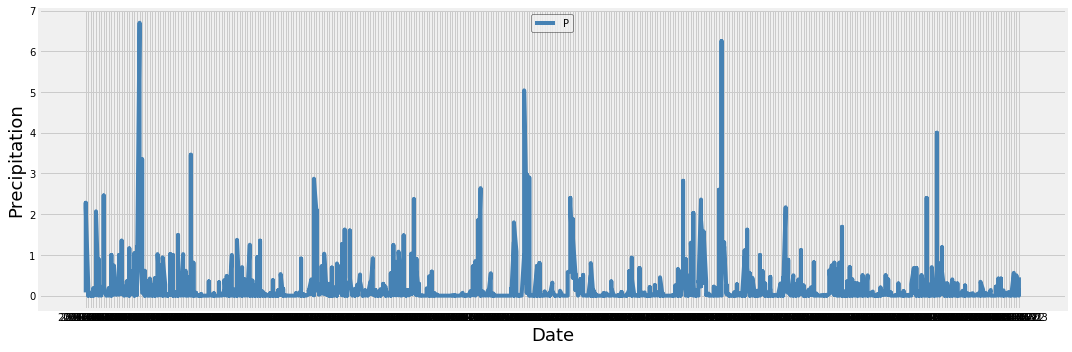

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data (ungrouped)
x_axis = results.index.values
y_axis = results['prcp score']
plt.figure(figsize=[15, 5])
plt.plot(x_axis, y_axis, color = 'steelblue')
plt.xlabel("Date", fontsize =18)
plt.ylabel("Precipitation", fontsize =18)
plt.legend(labels="Prcp", loc='upper center', frameon=True, edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.savefig("Image-Precipitation.png")
plt.show()


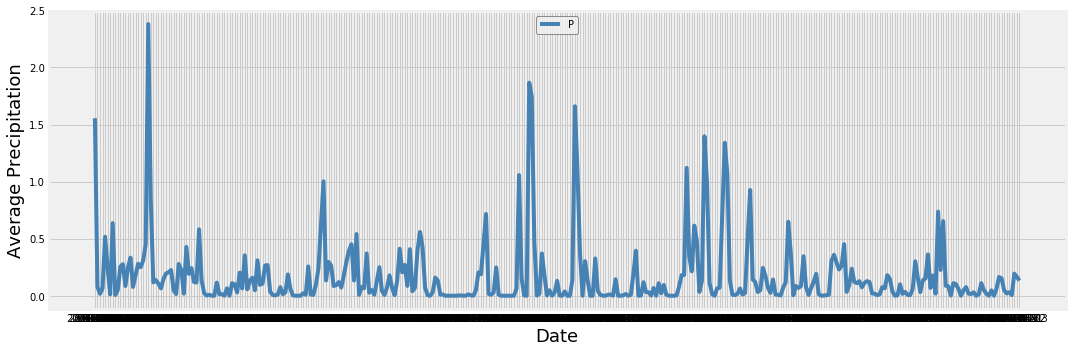

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data (avg prcp grouped by date)
x_axis = results_grouped.index.values
y_axis = results_grouped['avg prcp']
plt.figure(figsize=[15, 5])
plt.plot(x_axis, y_axis, color = 'steelblue')
plt.xlabel("Date", fontsize =18)
plt.ylabel("Average Precipitation", fontsize =18)
plt.legend(labels="Prcp", loc='upper center', frameon=True, edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.savefig("Image-AvgPrecipitation.png")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results.describe()

,prcp score
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"Total Stations: {stations}")

Total Stations: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, Station.name, func.count(Measurement.id) ).\
    filter(Measurement.station == Station.station ).  \
        group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
most_active

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [17]:
df = pd.DataFrame(most_active, columns = ['Station', 'Name', 'Count'])
id_selection =df["Station"][0]
print(id_selection)

USC00519281


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station:
most_active_temps= session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == id_selection).all()
df = pd.DataFrame(most_active_temps)


min_temp =df["tobs"].min()
max_temp =df["tobs"].max()
avg_temp =df["tobs"].mean()

print(f"For the most active station {id_selection}: Min Temp: {min_temp}, Max Temp: {max_temp}, Avg Temp: {round(avg_temp,1)}.")


For the most active station USC00519281: Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.7.


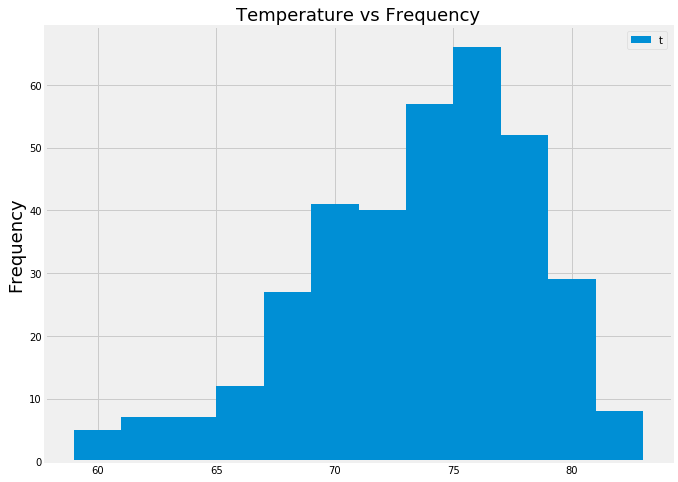

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_12_mo = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == id_selection).\
filter(Measurement.date >= start_date).all()

tobs_df = pd.DataFrame(most_active_12_mo, columns=['date', 'tobs'])
plt.figure(figsize=[10, 8])
plt.hist(tobs_df["tobs"], bins = 12)
plt.title("Temperature vs Frequency", fontsize =18)
plt.legend("tobs")
plt.ylabel("Frequency", fontsize =18)
plt.savefig("Image-Temperature.png")
plt.show()

# Addl Temperature Analysis

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_yr_start = '2016-12-01'
prev_yr_end =  '2016-12-05'

trip = calc_temps(prev_yr_start, prev_yr_end)
trip_df = pd.DataFrame(trip, columns=['t_min', 't_avg', 't_max'])

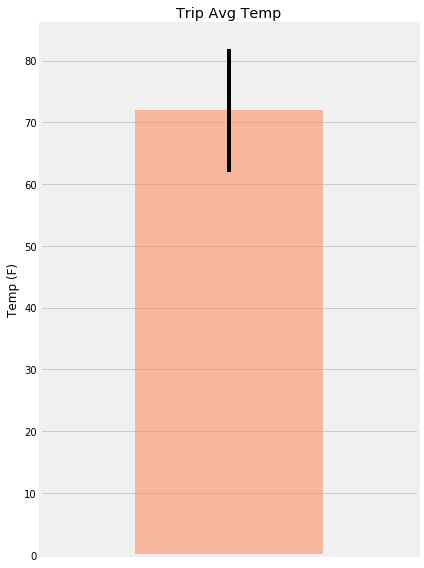

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='t_avg', 
                yerr=(trip_df['t_max'] - trip_df['t_min']),
                title='Trip Avg Temp', 
                color='coral', 
                alpha=0.5, 
                figsize=(6,8))

plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Image-TripAvgTemp.png")
plt.show()


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start, end):
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(precipitation(prev_yr_start, prev_yr_end))


[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.28), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.15), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.15), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.45), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.22), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start = '2019-12-01'
trip_end =  '2019-12-05'

# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_start, trip_end)
# Stip off the year and save a list of %m-%d strings
trip_dates = date_range.strftime('%m-%d')        

In [35]:
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_results = []
for i in trip_dates:
    daily_normals_results.append(*daily_normals(i))
daily_normals_results

[(65.0, 71.91666666666667, 78.0),
 (62.0, 71.32692307692308, 77.0),
 (67.0, 72.88679245283019, 79.0),
 (66.0, 72.17647058823529, 81.0),
 (64.0, 70.92156862745098, 78.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df =pd.DataFrame(daily_normals_results, columns = ['t_min', 't_avg', 't_max'])
normals_df['date'] = trip_dates
normals_df = normals_df.set_index('date')
normals_df

,t_min,t_avg,t_max
date,,,
12-01,65.0,71.916667,78.0
12-02,62.0,71.326923,77.0
12-03,67.0,72.886792,79.0
12-04,66.0,72.176471,81.0
12-05,64.0,70.921569,78.0


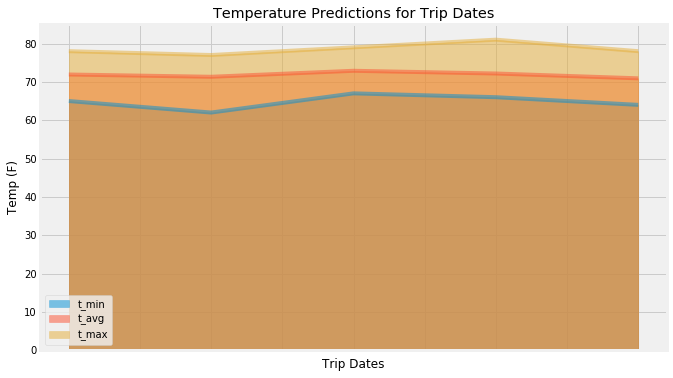

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', figsize=(10,6), stacked=False, title = "Temperature Predictions for Trip Dates", rot=45)
plt.xlabel('Trip Dates')
plt.ylabel('Temp (F)')
plt.savefig("Image-TempPredictionsForTripDates.png")
plt.show()